# PM10 Simulations

In [133]:
import os
import itertools
from unidecode import unidecode

import numpy as np
import pandas as pd
import geopandas as gpd
import skgstat as skg
import matplotlib.pyplot as plt
from skgstat import Variogram


VERBOSE = True  # Set to True to print out debug statements

List with cities of interest

In [134]:
cities = [
    'Tarnobrzeg',
    'Sanok',
    'Rzeszow',
    'Rymanow',
    'Przemysl',
    'Nisko',
    'Mielec',
    'Krosno',
    'Jaslo',
    'Jaroslaw',
    'Debica',
    'Jedlicze'
 ]

## Load PM10 data

### Read from csv file

In [166]:
pm10_df = pd.read_csv('pm10.csv', index_col=0)

### Drop missing values

In [167]:
pm10_df['Debica'] = pm10_df['Debica'].replace(' ', np.nan)
pm10_df['Debica'] = pm10_df['Debica'].astype(float)
pm10_df = pm10_df.dropna(axis=1, how='any')
pm10_df = pm10_df.set_index('Data')

In [173]:
if VERBOSE:
    print(pm10_df.head())
    print(pm10_df.describe())

        Tarnobrzeg        Sanok       Mielec     Jaroslaw
count  2136.000000  2136.000000  2136.000000  2136.000000
mean     23.298642    21.158614    22.088858    24.137594
std      17.456536    18.821306    17.985507    21.434639
min       3.800000     3.300000     3.100000     1.000000
25%      12.200000     9.800000    11.500000    11.500000
50%      19.400000    14.800000    17.500000    18.250000
75%      28.425000    23.800000    26.625000    28.625000
max     137.100000   165.100000   175.400000   190.600000


## Load cities shapefile

In [138]:
import geopandas as gpd

shapefile_path = "miasta/Wszystkie.shp"
gdf = gpd.read_file(shapefile_path)

In [139]:
if VERBOSE:
    print(gdf.head())
    print(gdf['STATION_NA'].unique())

                      INFO       STATION_CO                 STATION_NA  \
0    automatyczno-manualny     PmKosTargowa   Kościerzyna, ul. Targowa   
1             automatyczny     PmMalMickiew   Malbork, ul. Mickiewicza   
2    automatyczno-manualny     PmLebMalczew  Lębork, ul. Malczewskiego   
3             automatyczny     PmLinieKosci       Liniewko Kościerskie   
4             automatyczny     KpBydPlPozna   Bydgoszcz, pl. Poznański   
..                     ...              ...                        ...   
282  automatyczno-manualny     WpPoznSzwajc     Poznań ul. Szwajcarska   
283           automatyczny     WpMosinaCzer    Mosina, ul. Czereśniowa   
284  automatyczno-manualny     OpBrzegPoprz      Brzeg, ul. Poprzeczna   
285  automatyczno-manualny     LuNowaSolKos                   Nowa Sól   
286  automatyczno-manualny  MpWadowiBalyMOB       Wadowice, ul. Bałysa   

                       ADDRESS                   geometry  
0     Kościerzyna, ul. Targowa  POINT (17.97586 54.

### Remove polish signs

In [140]:
for col in gdf.select_dtypes(include=[object]):
    gdf[col] = gdf[col].apply(unidecode)

In [174]:
if VERBOSE:
    print(gdf['STATION_NA'].unique())
    for city in cities:
        print(gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique())

['Koscierzyna, ul. Targowa' 'Malbork, ul. Mickiewicza'
 'Lebork, ul. Malczewskiego' 'Liniewko Koscierskie'
 'Bydgoszcz, pl. Poznanski' 'Bydgoszcz, ul. Warszawska'
 'Ciechocinek, ul. Tezniowa' 'Radomsko, ul. Rolna'
 'Grudziadz, ul. Sienkiewicza' 'Koniczynka, Pojezierze Chelminskie'
 'Jarczew, IMGW' 'Krasnik, ul. Koszarowa' 'Lublin, ul. Sliwinskiego'
 'Lublin, ul. Obywatelska' 'Radzyn Podlaski, ul. Sitkowskiego'
 'Torun, ul. Dziewulskiego' 'Torun, ul. Przy Kaszowniku'
 'Wloclawek, ul. Okrzei' 'Zielonka, Bory Tucholskie'
 'Biala Podlaska, ul. Orzechowa' 'Olawa, ul. Zolnierzy Armii Krajowej'
 'Olesnica, ul. Brzozowa' 'Osieczow' 'Polkowice, ul. Kasztanowa' 'Sniezka'
 'Szczawno-Zdroj, ul. Kolejowa' 'Gajew, Ujecie Wody' 'Lodz, ul. Czernika'
 'Lodz, ul. Gdanska' 'Lodz, ul. Legionow' 'Lodz, ul. Rudzka'
 'Pabianice, ul. Konstantynowska' 'Pabianice, ul. Kilinskiego'
 'Parzniewice, Ujecie Wody'
 'Piotrkow Trybunalski, ul. Krakowskie Przedmiescie'
 'Jaslo, ul. Sikorskiego' 'Krosno, ul. Kletowki' 'N

### Get columns with cities from Podkarpacie

In [143]:
columns = [gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique() for city in cities] 
columns = list(itertools.chain.from_iterable(columns))  # flatten the list
columns = [column for column in columns if column != 'Szczecinek, ul. Przemyslowa']

In [144]:
if VERBOSE:
    print(columns)

['Tarnobrzeg, ul. Dabrowskiej', 'Sanok, ul. Sadowa', 'Rzeszow, ul. Rejtana', 'Rzeszow, ul. Pilsudskiego', 'Rzeszow, ul. Starzynskiego', 'Rzeszow, ul. Slocinska', 'Rymanow Zdroj, ul. Parkowa', 'Przemysl, ul. Grunwaldzka', 'Nisko, ul. Szklarniowa', 'Mielec, ul. Biernackiego', 'Mielec, ul. Pogodna', 'Krosno, ul. Kletowki', 'Jaslo, ul. Sikorskiego', 'Jaroslaw, ul. Pruchnicka', 'Debica, ul.Grottgera', 'Jedlicze, ul. Tokarskich']


### Create a subset for Podkarpacie

In [145]:
gdf_podkarpacie = gdf.loc[gdf['STATION_NA'].isin(columns)]

### Drop redundant columns

In [146]:
gdf_podkarpacie = gdf_podkarpacie.drop(['INFO', 'STATION_CO', 'ADDRESS'], axis=1)

In [147]:
if VERBOSE:
    print(gdf_podkarpacie)

                      STATION_NA                   geometry
35        Jaslo, ul. Sikorskiego  POINT (21.45462 49.74489)
36          Krosno, ul. Kletowki  POINT (21.74970 49.69017)
37        Nisko, ul. Szklarniowa  POINT (22.11247 50.52989)
121            Sanok, ul. Sadowa  POINT (22.19589 49.57173)
122  Tarnobrzeg, ul. Dabrowskiej  POINT (21.68837 50.57574)
136     Jaroslaw, ul. Pruchnicka  POINT (22.67477 50.01208)
170    Przemysl, ul. Grunwaldzka  POINT (22.75624 49.78434)
171         Rzeszow, ul. Rejtana  POINT (22.01058 50.02424)
185         Debica, ul.Grottgera  POINT (21.41626 50.05479)
188     Mielec, ul. Biernackiego  POINT (21.44094 50.29913)
210          Mielec, ul. Pogodna  POINT (21.48637 50.31804)
214    Rzeszow, ul. Pilsudskiego  POINT (22.00466 50.04068)
216   Rymanow Zdroj, ul. Parkowa  POINT (21.85101 49.54654)
277   Rzeszow, ul. Starzynskiego  POINT (21.98051 50.06038)
278       Rzeszow, ul. Slocinska  POINT (22.04794 50.02486)
279     Jedlicze, ul. Tokarskich  POINT 

## Load voivodeship shapefile

In [148]:
shapefile_path = "wojewodztwa/wojewodztwa.shp"
gdf_woj = gpd.read_file(shapefile_path)

In [149]:
if VERBOSE:
    print(gdf_woj)
    print(gdf_woj['JPT_NAZWA_'].unique())

   gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE           JPT_NAZWA_ JPT_ORGAN_  \
0    None        WOJ    2289315         32   zachodniopomorskie       None   
1    None        WOJ    1398751         08             lubuskie       None   
2    None        WOJ    1994777         02         dolnośląskie       None   
3    None        WOJ    2982700         30        wielkopolskie       None   
4    None        WOJ    1831001         22            pomorskie       None   
5    None        WOJ     941272         16             opolskie       None   
6    None        WOJ    1797058         04   kujawsko-pomorskie       None   
7    None        WOJ    1233406         24              śląskie       None   
8    None        WOJ    1821720         10              łódzkie       None   
9    None        WOJ    1518007         12          małopolskie       None   
10   None        WOJ    2417419         28  warmińsko-mazurskie       None   
11   None        WOJ    3555920         14          mazowieckie 

### Create a subset with Podkarpacie voivodeship

In [150]:
gdf_podkarpacie_woj = gdf_woj.loc[gdf_woj['JPT_NAZWA_'].isin(['podkarpackie'])]

In [151]:
if VERBOSE:
    print(gdf_podkarpacie_woj)

   gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE    JPT_NAZWA_ JPT_ORGAN_  \
13   None        WOJ    1784523         18  podkarpackie       None   

   JPT_JOR_ID WERSJA_OD WERSJA_DO  WAZNY_OD  ...   JPT_ID JPT_POWI_1  \
13          0  20221206         0  20120926  ...  1366391          0   

   JPT_KJ_I_3 JPT_GEOMET JPT_GEOM_1     SHAPE_LENG     SHAPE_AREA  \
13       None          0          0  11.2224322272  2.23569279514   

             REGON       RODZAJ  \
13  69058132400000  wojewodztwo   

                                             geometry  
13  POLYGON ((819920.700 271467.820, 819598.610 27...  

[1 rows x 37 columns]


## Plot cities and voivodeship

<Axes: >

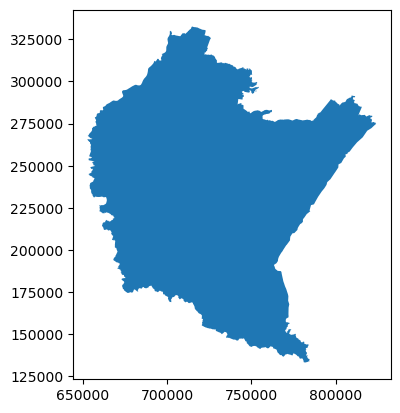

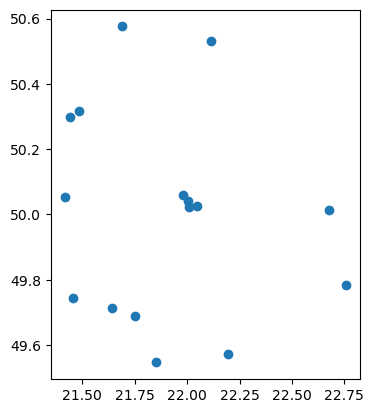

In [152]:
gdf_podkarpacie_woj.plot()
gdf_podkarpacie.plot()

Since cities and voivodeship we will focus on cities only

## Prepare data for interpolation

### Get addresses from Podkarpacie GDF and cities from PM10 DF

In [153]:
addresses = gdf_podkarpacie['STATION_NA'].unique()
cities = pm10_df.columns[1:]

### Unify `STATION_NA` values to match PM10 cities

First match the cities

In [154]:
gdf_podkarpacie_cities = gdf_podkarpacie.copy()

for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[0] in address), None)
    if not matched_city or len(matched_city.split('_')) > 1:
        continue
    
    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

if VERBOSE:
    print(gdf_podkarpacie_cities)

                      STATION_NA                   geometry
35                         Jaslo  POINT (21.45462 49.74489)
36                        Krosno  POINT (21.74970 49.69017)
37                         Nisko  POINT (22.11247 50.52989)
121                        Sanok  POINT (22.19589 49.57173)
122  Tarnobrzeg, ul. Dabrowskiej  POINT (21.68837 50.57574)
136                     Jaroslaw  POINT (22.67477 50.01208)
170                     Przemysl  POINT (22.75624 49.78434)
171         Rzeszow, ul. Rejtana  POINT (22.01058 50.02424)
185         Debica, ul.Grottgera  POINT (21.41626 50.05479)
188                       Mielec  POINT (21.44094 50.29913)
210                       Mielec  POINT (21.48637 50.31804)
214    Rzeszow, ul. Pilsudskiego  POINT (22.00466 50.04068)
216   Rymanow Zdroj, ul. Parkowa  POINT (21.85101 49.54654)
277   Rzeszow, ul. Starzynskiego  POINT (21.98051 50.06038)
278       Rzeszow, ul. Slocinska  POINT (22.04794 50.02486)
279     Jedlicze, ul. Tokarskich  POINT 

Secondly match the street (i.e. `Rzeszow, ul. Rejtana` == `Rzeszow_Rejtana`)

In [155]:
for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[-1] in address), None)
    if not matched_city:
        continue
    
    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

if VERBOSE:
    print(gdf_podkarpacie_cities)

                      STATION_NA                   geometry
35                         Jaslo  POINT (21.45462 49.74489)
36                        Krosno  POINT (21.74970 49.69017)
37                         Nisko  POINT (22.11247 50.52989)
121                        Sanok  POINT (22.19589 49.57173)
122  Tarnobrzeg, ul. Dabrowskiej  POINT (21.68837 50.57574)
136                     Jaroslaw  POINT (22.67477 50.01208)
170                     Przemysl  POINT (22.75624 49.78434)
171              Rzeszow_Rejtana  POINT (22.01058 50.02424)
185         Debica, ul.Grottgera  POINT (21.41626 50.05479)
188                       Mielec  POINT (21.44094 50.29913)
210                       Mielec  POINT (21.48637 50.31804)
214         Rzeszow_Pilsudskiego  POINT (22.00466 50.04068)
216                Rymanow_Zdroj  POINT (21.85101 49.54654)
277   Rzeszow, ul. Starzynskiego  POINT (21.98051 50.06038)
278       Rzeszow, ul. Slocinska  POINT (22.04794 50.02486)
279     Jedlicze, ul. Tokarskich  POINT 

### Drop unmatched columns and duplicates

In [156]:
for city in gdf_podkarpacie_cities['STATION_NA']:
    if "," in city:
        gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop(gdf_podkarpacie_cities[gdf_podkarpacie_cities['STATION_NA'] == city].index)

gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop_duplicates(subset=['STATION_NA'])

In [157]:
if VERBOSE:
    print(gdf_podkarpacie_cities)

               STATION_NA                   geometry
35                  Jaslo  POINT (21.45462 49.74489)
36                 Krosno  POINT (21.74970 49.69017)
37                  Nisko  POINT (22.11247 50.52989)
121                 Sanok  POINT (22.19589 49.57173)
136              Jaroslaw  POINT (22.67477 50.01208)
170              Przemysl  POINT (22.75624 49.78434)
171       Rzeszow_Rejtana  POINT (22.01058 50.02424)
188                Mielec  POINT (21.44094 50.29913)
214  Rzeszow_Pilsudskiego  POINT (22.00466 50.04068)
216         Rymanow_Zdroj  POINT (21.85101 49.54654)


## Create Variogram

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


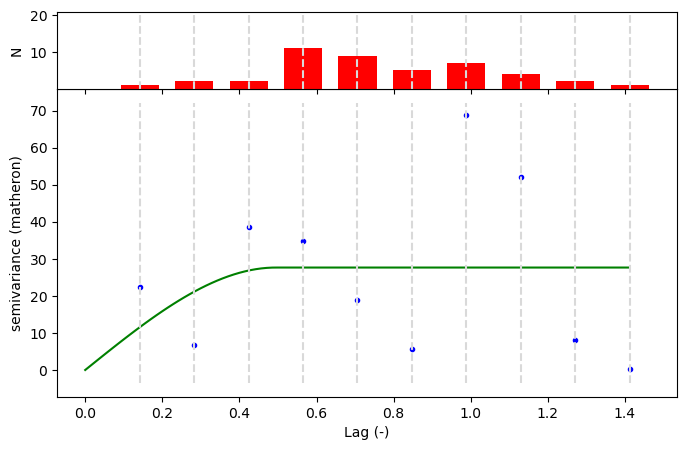

In [184]:
for _, row in pm10_df.iterrows():
    row.name = "contamination"
    data = gdf_podkarpacie_cities.join(row, on='STATION_NA')
    
    coordinates = data['geometry'].apply(lambda p: (p.x, p.y)).tolist()
    values = list(map(float, data['contamination'].tolist()))

    V = Variogram(coordinates, values, model='spherical', maxlag=20, n_lags=10)

    fig = V.plot()
    plt.show()
    break

## Ordinary Kriging

In [185]:
def interpolate(V, ax, max_x, max_y, min_x, min_y):
    xx, yy = np.mgrid[min_x:max_x:100j, min_y:max_y:100j]
    ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    art = ax.matshow(field, origin='lower', cmap='plasma', vmin=V.values.min(), vmax=V.values.max())
    ax.set_title('%s model' % V.model.__name__)
    plt.colorbar(art, ax=ax)
    return field

### Set max and min values for interpolation meshgrid

In [186]:
max_x = max(point.x for point in gdf_podkarpacie_cities['geometry'])
max_y = max(point.y for point in gdf_podkarpacie_cities['geometry'])
min_x = min(point.x for point in gdf_podkarpacie_cities['geometry'])
min_y = min(point.y for point in gdf_podkarpacie_cities['geometry'])

### Plot interpolation

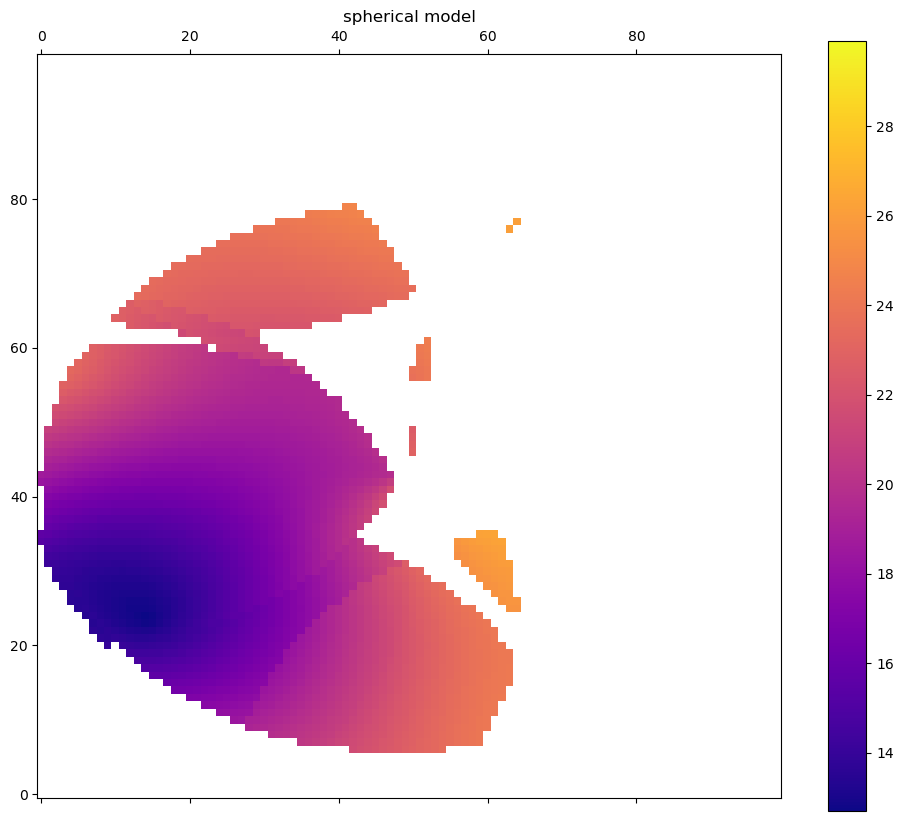

In [187]:
fields = []
fig, _a = plt.subplots(1,1, figsize=(12, 10), sharex=True, sharey=True)
axes = _a
fields.append(interpolate(V, axes, max_x, max_y, min_x, min_y))
# axes.plot(gdf_podkarpacie_cities['geometry'].x, gdf_podkarpacie_cities['geometry'].y, 'k.')